In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from ruzicka.test_metrics import minmax
from ruzicka.test_metrics import cosine

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

In [3]:
stops_tidy = pd.read_csv("../data/corpus_rhet.csv", index_col=0)
stops_tidy = stops_tidy[stops_tidy.Translator != "Myst"]
stops_tidy

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1197,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1198,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1199,Bur,uxorem suam et concepit et genuit quare propte...,Fid,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [4]:
feat_cols = stops_tidy.columns[3:]

In [5]:
def balanced_subsample(
    y, size=None, rng: np.random.Generator = np.random.default_rng()
):
    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = rng.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample


def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
    balance: bool = False,
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    pdy = pd.Series(y)
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n * 2):
        if balance:
            # Balances the sample down to the least abundant class
            ss = balanced_subsample(pdy, rng=rng)  # indices into y
            candidates = X[np.where(y[ss] == cand_idx)]
            others = X[np.where(y[ss] != cand_idx)]
        try:
            # This try is to catch subsamples from sparse data where some column
            # subsets are just empty and so the distance metrics yield divzero.
            # We try for n*2 iterations, returning early when we have n and
            # raising if we don't get there.

            # from 1d vectors, choose (pct * width_of_X) random column indices (no
            # replacement)
            ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

            # compare the test vector to one in-sample and one outsample (with
            # bootstrap columns), then record the difference of distances
            if method == "random":
                in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
                out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
                differences.append(out_dist - in_dist)

            # compare the test vector to the closest in-sample and out-sample, then
            # record the difference of distances (like vanilla Kestemont GI)
            elif method == "closest":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]
                differences.append(min(out_dists) - min(in_dists))

            # compare the test vector to the closest in-sample and out-sample, then
            # record the scaled difference of distances for the smallest 3 (like
            # Kestemont GI with Eder Boostrap Consensus Tree stye ranking)
            elif method == "ranked":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]

                # faster than sorting and slicing
                top_in = heapq.nsmallest(3, in_dists)
                top_out = heapq.nsmallest(3, out_dists)
                d = 0
                for nn in range(3):
                    # smallest distances are unscaled, seccond is halved, etc
                    d += (top_out[nn] - top_in[nn]) / (nn + 1)
                differences.append(d)
            else:
                raise ValueError(
                    f"Unsupported method {method}, valid are: random, closest, ranked"
                )
        except ZeroDivisionError:
            continue
        if len(differences) >= n:
            return differences
    raise ValueError("Too many ZeroDivisionErrors. Data too sparse?")

In [6]:
problems = stops_tidy[stops_tidy.Work == "Rhet"].reset_index(drop=True).copy()
problems.head()

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bxx,rethorica est convertibilis dialetice utreque ...,Rhet,0.0,0.394042,0.497737,0.0,0.0,0.0,0.020739,...,0.062217,0.041478,0.0,0.020739,0.165912,0.228129,0.0,0.0,0.331825,0.0
1,Bxx,iuverit maxime utens iuste et leserit iniuste ...,Rhet,0.0,0.277810,0.590345,0.0,0.0,0.0,0.052089,...,0.052089,0.156268,0.0,0.034726,0.121542,0.069452,0.0,0.0,0.347262,0.0
2,Bxx,horum cognitum non oportet dicere ipse enim au...,Rhet,0.0,0.267038,0.534076,0.0,0.0,0.0,0.066759,...,0.050070,0.233658,0.0,0.000000,0.183588,0.066759,0.0,0.0,0.317107,0.0
3,Bxx,quomodo non lesit quoniam autem iniustificat n...,Rhet,0.0,0.524604,0.671493,0.0,0.0,0.0,0.000000,...,0.020984,0.041968,0.0,0.020984,0.104921,0.125905,0.0,0.0,0.104921,0.0
4,Bxx,sunt ex quibus autem oportet et de hiis et ali...,Rhet,0.0,0.636098,0.371057,0.0,0.0,0.0,0.070678,...,0.070678,0.035339,0.0,0.000000,0.088347,0.141355,0.0,0.0,0.512412,0.0


In [7]:
problems["Chunk"] = problems.apply(lambda r: f"{r.Translator}{r.Work}{r.name}", axis=1)

In [8]:
comparison = stops_tidy[stops_tidy.Work != "Rhet"].reset_index(drop=True).copy()
comparison

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,Bur,uxorem suam et concepit et genuit quare propte...,Fid,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [47]:
comparison[comparison.Translator == "Bar"]

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
173,Bar,ï»¿ quoniam eligimus dicere de moralibus primu...,Mor,0.0,0.142481,0.554092,0.000000,0.0,0.000000,0.031662,...,0.000000,0.031662,0.000000,0.000000,0.094987,0.237468,0.0,0.0,0.063325,0.000000
174,Bar,non est dicendum de ydea etiam arbitrantur opo...,Mor,0.0,0.034874,0.732348,0.000000,0.0,0.034874,0.000000,...,0.069747,0.052311,0.000000,0.000000,0.052311,0.261553,0.0,0.0,0.069747,0.000000
175,Bar,vivimus per virtutem ergo anime bene vivemus b...,Mor,0.0,0.113858,0.645195,0.000000,0.0,0.018976,0.000000,...,0.018976,0.018976,0.000000,0.000000,0.113858,0.360550,0.0,0.0,0.000000,0.000000
176,Bar,habere bene autem habere ad hec est neque secu...,Mor,0.0,0.187494,0.664751,0.000000,0.0,0.000000,0.000000,...,0.000000,0.034090,0.000000,0.000000,0.051135,0.323853,0.0,0.0,0.000000,0.000000
177,Bar,concupiscentia ira voluntas primum quidem ergo...,Mor,0.0,0.160510,0.570701,0.000000,0.0,0.000000,0.089172,...,0.000000,0.035669,0.000000,0.000000,0.035669,0.285351,0.0,0.0,0.053503,0.000000
178,Bar,ex principio determinato acceperunt propter qu...,Mor,0.0,0.301441,0.559820,0.000000,0.0,0.000000,0.021532,...,0.000000,0.043063,0.000000,0.000000,0.043063,0.473694,0.0,0.0,0.021532,0.000000
179,Bar,bonum et hoc faciens quamvis presens sit quis ...,Mor,0.0,0.117205,0.753461,0.000000,0.0,0.000000,0.000000,...,0.000000,0.050231,0.000000,0.000000,0.016744,0.334872,0.0,0.0,0.016744,0.000000
180,Bar,sunt existentia indigno existenti tristitia qu...,Mor,0.0,0.065372,0.833494,0.000000,0.0,0.000000,0.000000,...,0.000000,0.098058,0.000000,0.000000,0.032686,0.114401,0.0,0.0,0.032686,0.000000
181,Bar,hiis et dictis ante iustitia que circa hec uti...,Mor,0.0,0.129965,0.617336,0.000000,0.0,0.000000,0.016246,...,0.016246,0.064983,0.000000,0.000000,0.081228,0.406142,0.0,0.0,0.016246,0.000000
182,Bar,volentes iniustum patientur ad has autem ratio...,Mor,0.0,0.100769,0.725535,0.000000,0.0,0.000000,0.040308,...,0.000000,0.000000,0.000000,0.000000,0.080615,0.382921,0.0,0.0,0.060461,0.000000


In [10]:
lenc = LabelEncoder()
labels = lenc.fit_transform(stops_tidy.Translator)

In [11]:
comparison.Translator.value_counts()

Wil      554
Bur      368
Jam       87
Anon      66
Bar       43
Arist     35
Name: Translator, dtype: int64

In [13]:
comparison[feat_cols]

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,0.0,0.024275,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,0.0,0.000000,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,0.0,0.023002,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,0.0,0.014118,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,0.0,0.000000,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,0.0,0.000000,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [24]:
ss = StandardScaler(with_mean=False).fit(comparison[feat_cols])

In [25]:
X = ss.transform(comparison[feat_cols])
y = np.array(lenc.transform(comparison.Translator))

In [26]:
probs_X = ss.transform(problems[feat_cols])
problem_dict = dict(zip(problems.Chunk, probs_X))

In [38]:
pd.DataFrame(probs_X)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.0,2.821000,2.590573,0.000000,0.0,0.000000,0.220970,0.0,0.0,0.0,...,1.110756,0.754099,0.0,0.550133,1.344407,2.614487,0.000000,0.0,2.189764,0.0
1,0.0,1.988878,3.072573,0.000000,0.0,0.000000,0.555001,0.0,0.0,0.0,...,0.929945,2.841055,0.0,0.921162,0.984867,0.795962,0.000000,0.0,2.291639,0.0
2,0.0,1.911761,2.779705,0.000000,0.0,0.000000,0.711309,0.0,0.0,0.0,...,0.893887,4.248060,0.0,0.000000,1.487640,0.765100,0.000000,0.0,2.092643,0.0
3,0.0,3.755713,3.494921,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.374628,0.763012,0.0,0.556635,0.850186,1.442939,0.000000,0.0,0.692389,0.0
4,0.0,4.553916,1.931243,0.000000,0.0,0.000000,0.753056,0.0,0.0,0.0,...,1.261799,0.642483,0.0,0.000000,0.715886,1.620007,0.000000,0.0,3.381492,0.0
5,0.0,3.592946,1.351074,0.000000,0.0,0.000000,0.184390,0.0,0.0,0.0,...,0.308959,3.146311,0.0,0.000000,1.402310,2.181673,0.000000,0.0,2.512484,0.0
6,0.0,3.199384,0.882259,0.999125,0.0,0.000000,0.164192,0.0,0.0,0.0,...,0.550232,1.681003,0.0,1.226330,0.998964,1.766089,0.000000,0.0,2.542355,0.0
7,0.0,2.000164,2.908243,0.000000,0.0,0.000000,0.637886,0.0,0.0,0.0,...,0.712550,1.814080,0.0,0.529365,0.646828,0.914833,0.000000,0.0,2.897265,0.0
8,0.0,2.189762,2.160516,0.000000,0.0,0.000000,0.232784,0.0,0.0,0.0,...,0.780094,2.780455,0.0,1.159089,1.770355,2.003103,0.000000,0.0,1.297596,0.0
9,0.0,3.440104,1.532846,1.004989,0.0,0.000000,0.165156,0.0,0.0,0.0,...,0.000000,0.281812,0.0,1.233528,0.502414,1.243519,0.000000,0.0,3.682479,0.0


In [27]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Wil"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Wil"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

wil_df = pd.DataFrame(results)

In [28]:
s = "Wil"
for c in wil_df.columns[wil_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(wil_df[c], 0):5.2f}  {sp.stats.skew(wil_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

WilRhet14       80.00   0.27
WilRhet15       96.20   0.27
WilRhet16       98.80   0.49
WilRhet17       81.20   0.15
WilRhet18       76.50   0.14
WilRhet19       87.70   0.39
WilRhet20       82.50   0.16
WilRhet21       96.50   0.63
WilRhet22       73.20   0.48
WilRhet23       85.50   0.25
WilRhet24       64.90   0.48
WilRhet25       73.00   0.21
WilRhet26       76.10   0.25
WilRhet27       95.50   0.31
WilRhet28       75.10   0.18

Match % -- Mean: 82.85 Std:  9.93
Skew    -- Mean:  0.31 Std:  0.14


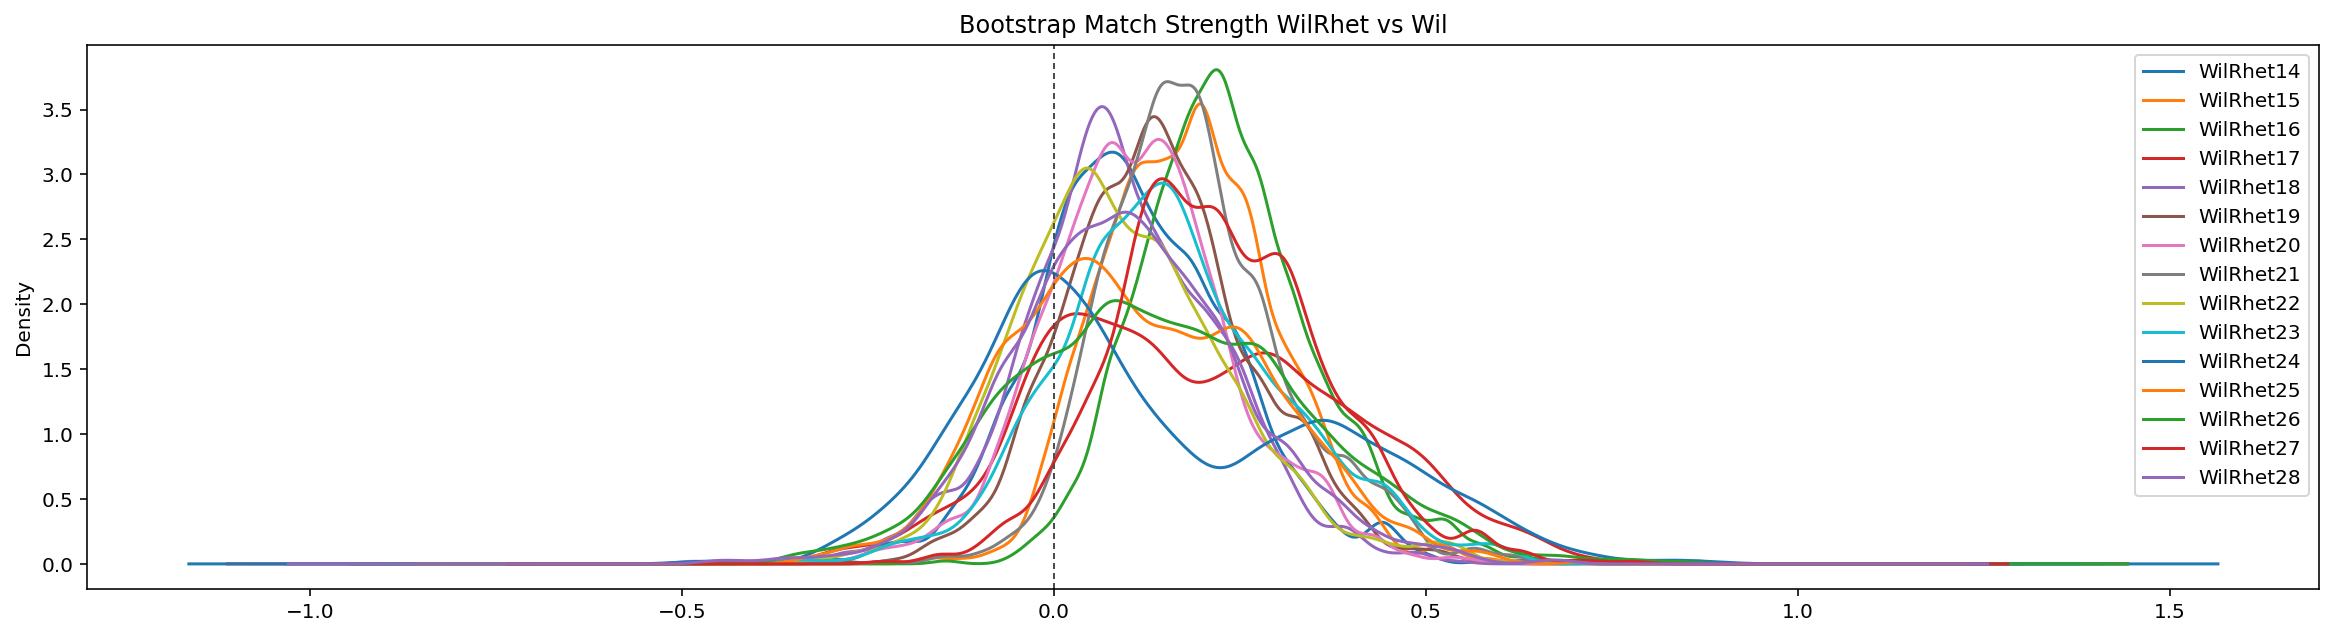

In [29]:
ax = wil_df[wil_df.columns[wil_df.columns.str.startswith("Wil")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(20, 5),
    title="Bootstrap Match Strength WilRhet vs Wil",
)
ax.axvline(0, color=".3", dashes=(3, 2), linewidth=1)

In [44]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Bxx"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Bar"])[0],  # type: ignore
        1000,
        0.5,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=True,
    )
    results[work] = bs

bxx_df = pd.DataFrame(results)

In [45]:
s = "Bxx"
for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(bxx_df[c], 0):5.2f}  {sp.stats.skew(bxx_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

BxxRhet0        41.20  -0.40
BxxRhet1        31.60  -0.11
BxxRhet2        13.60  -0.27
BxxRhet3         0.90  -0.08
BxxRhet4        37.80  -0.46
BxxRhet5        17.80  -0.26
BxxRhet6        11.20  -0.09
BxxRhet7        38.80  -0.67
BxxRhet8        34.00  -0.50
BxxRhet9        44.20  -0.51
BxxRhet10       47.10  -0.75
BxxRhet11       12.00  -0.01
BxxRhet12       21.80  -0.46
BxxRhet13       20.50  -0.58

Match % -- Mean: 26.61 Std: 13.93
Skew    -- Mean: -0.37 Std:  0.23


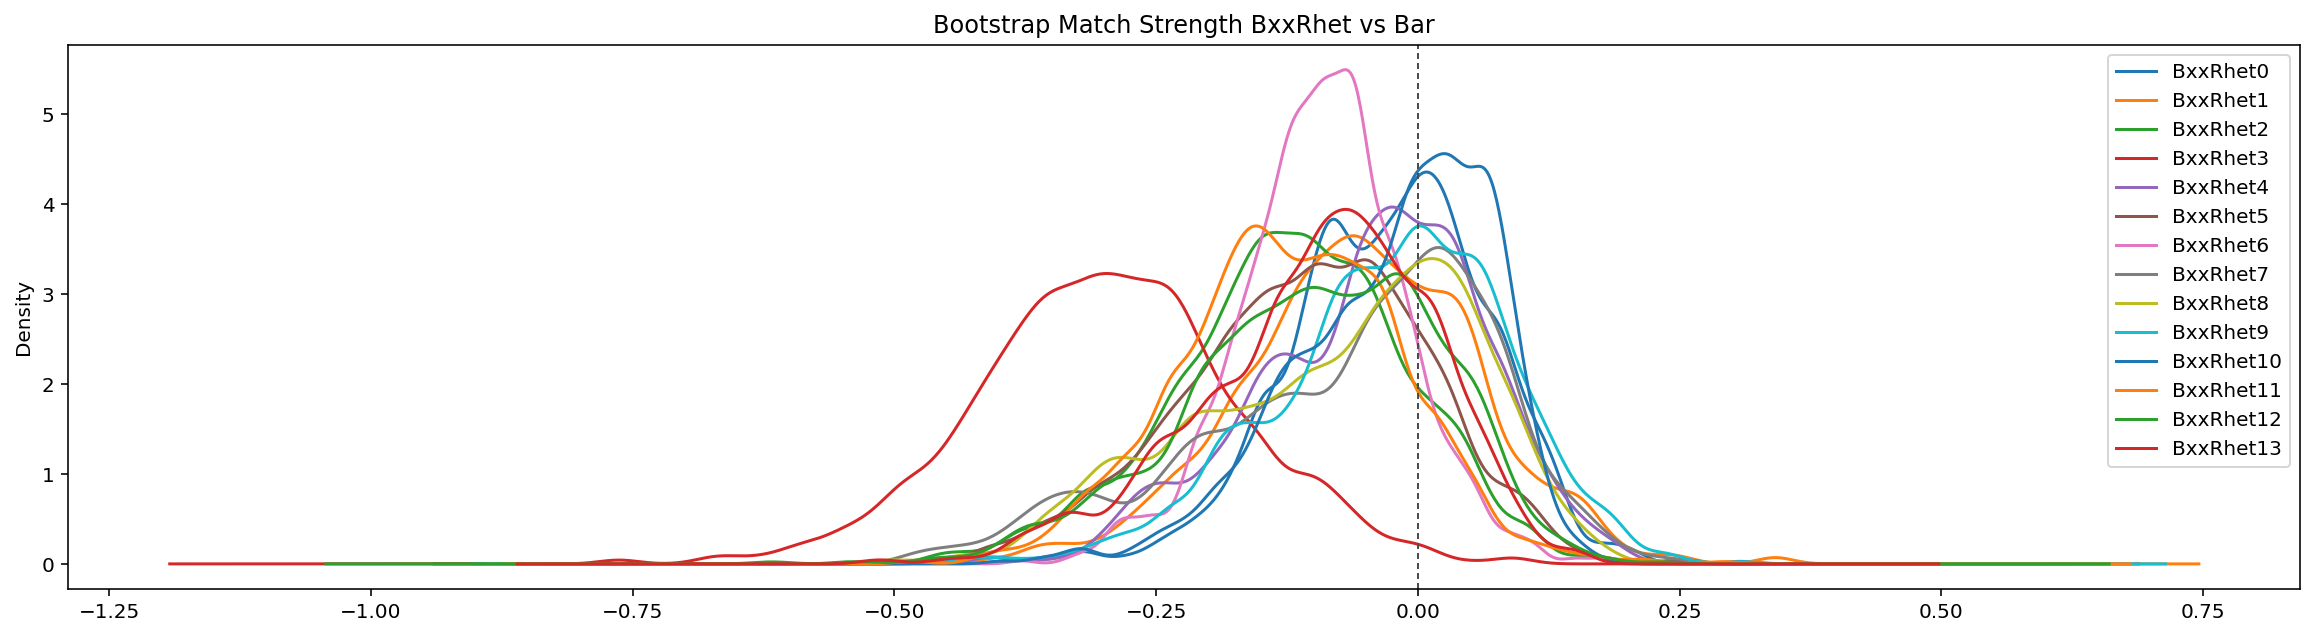

In [46]:
ax = bxx_df[bxx_df.columns[bxx_df.columns.str.startswith("Bxx")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(20, 5),
    title="Bootstrap Match Strength BxxRhet vs Bar",
)
ax.axvline(0, color=".3", dashes=(3, 2), linewidth=1)

In [60]:
def bs_row(r):
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, r.name, 0),
        np.delete(y, r.name),
        lenc.transform([r.Translator])[0],
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    return 100 - sp.stats.percentileofscore(bs, 0)

In [67]:
r = comparison.apply(bs_row, axis=1)
sp.stats.describe(r)

DescribeResult(nobs=1153, minmax=(7.299999999999997, 100.0), mean=84.87671292281007, variance=294.2550323281054, skewness=-1.9395597883465006, kurtosis=3.9018007025230315)

In [ ]:
comparison.insert(3, "Match", r)
comparison

,Translator,Chunk,Work,Match,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,71.9,0.0,0.097100,0.534050,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,73.6,0.0,0.200297,0.578636,0.0,0.0,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,81.5,0.0,0.230022,0.575055,0.0,0.0,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,77.0,0.0,0.243044,0.710436,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,44.2,0.0,0.649435,0.409426,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,65.1,0.0,0.024500,0.538996,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,61.4,0.0,0.000000,0.421459,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,67.3,0.0,0.000000,0.738485,0.0,0.0,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,Bur,uxorem suam et concepit et genuit quare propte...,Fid,82.7,0.0,0.000000,0.666795,0.0,0.0,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [115]:
import seaborn as sns

In [139]:
compound = comparison.apply(lambda r: f"{r['Translator']}-{r['Work']}", axis=1)

In [140]:
sbdf = comparison.copy()
sbdf["CompoundWork"] = compound

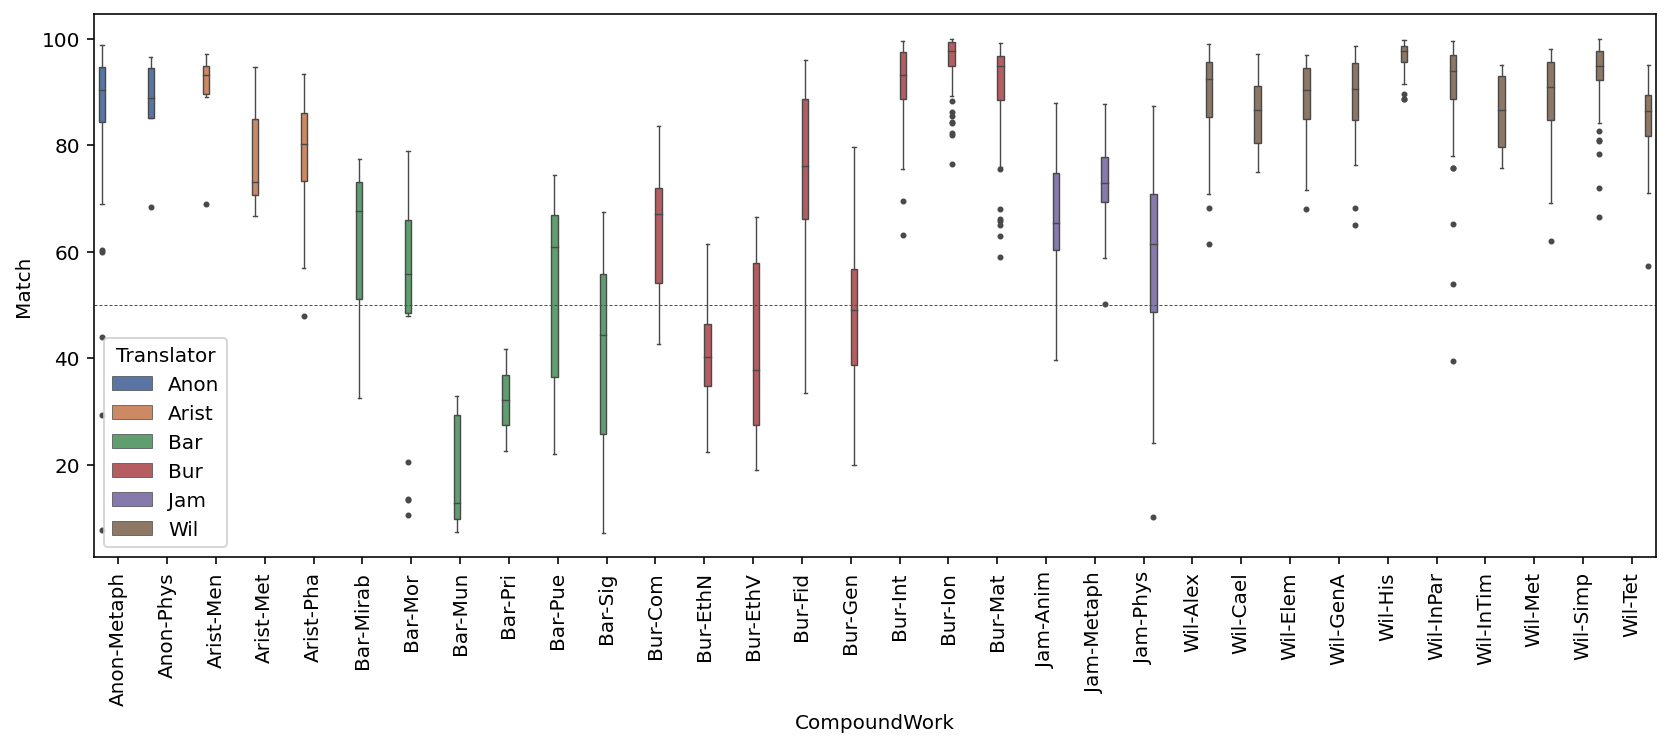

In [250]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.xticks(rotation=90)

sax = sns.boxplot(
    ax=ax,
    data=sbdf.sort_values(by="CompoundWork"),
    x="CompoundWork",
    y="Match",
    hue="Translator",
    linewidth=0.7,
    palette="deep",
    fliersize=2,
    flierprops={"marker": "o"},
)
sax.axhline(50, color=".3", dashes=(3, 2), linewidth=0.5)

In [245]:
comparison[comparison.Work == "Phys"][comparison.Translator == "Anon"]

/var/folders/wt/_hvfndq56jvd5k42nrkq9fy00000gn/T/ipykernel_20976/2936714822.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comparison[comparison.Work == "Phys"][comparison.Translator == "Anon"]


,Translator,Chunk,Work,Match,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
592,Anon,quoniam agnoscere et scire circa methodos omne...,Phys,88.9,0.0,0.701313,0.292214,0.0,0.0,0.0,...,0.038962,0.000000,0.000000,0.000000,0.214290,0.0,0.019481,0.019481,0.370138,0.0
593,Anon,deinde et hoc inconueniens omnis arbitrari ess...,Phys,68.5,0.0,0.446292,0.263718,0.0,0.0,0.0,...,0.101430,0.020286,0.000000,0.020286,0.182574,0.0,0.000000,0.000000,0.324576,0.0
594,Anon,fiunt sed secernuntur inentia dicuntur autem a...,Phys,85.1,0.0,0.298791,0.390727,0.0,0.0,0.0,...,0.022984,0.000000,0.022984,0.022984,0.298791,0.0,0.000000,0.000000,0.528631,0.0
595,Anon,entium substantiam contraria principium uero n...,Phys,96.6,0.0,0.381375,0.281013,0.0,0.0,0.0,...,0.080290,0.000000,0.000000,0.000000,0.441593,0.0,0.020072,0.000000,0.541955,0.0
596,Anon,natura scibilis secundum analogiam sicut enim ...,Phys,94.5,0.0,0.589540,0.294770,0.0,0.0,0.0,...,0.136048,0.022675,0.000000,0.022675,0.204072,0.0,0.000000,0.000000,0.430818,0.0


In [53]:
experiment = comparison[(comparison.Translator != "Bar") | (comparison.Work == "Mor")]

In [56]:
experiment

,Translator,Chunk,Work,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,quoniam quidem ex calido et frigido et sicco e...,Com,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,sermo non quod nunquam fit in uno eodemque cor...,Com,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,horis anni invenire quartam coniugationem comp...,Com,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,quod necesse est in ea putrefieri omnia incipi...,Com,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,de ipsis per capitula quantum ad presentia uti...,Com,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,Bur,ostendat quod secundum veritatem est homo cum ...,Fid,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1149,Bur,causative dicere ut hoc tibi soli peccavi et p...,Fid,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1150,Bur,condemnavit peccatum in carne ut iustitia legi...,Fid,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1151,Bur,uxorem suam et concepit et genuit quare propte...,Fid,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [58]:
experiment_X = ss.transform(experiment[feat_cols])
experiment_y = np.array(lenc.transform(experiment.Translator))

In [59]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Bxx"):
        continue
    bs = bootstrap_imposters(
        vec,
        experiment_X,
        experiment_y,
        lenc.transform(["Bar"])[0],  # type: ignore
        1000,
        0.5,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=True,
    )
    results[work] = bs

bxx_df = pd.DataFrame(results)

In [60]:
s = "Bxx"
for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(bxx_df[c], 0):5.2f}  {sp.stats.skew(bxx_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.mean(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(bxx_df[c], 0)
    for c in bxx_df.columns[bxx_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

BxxRhet0        26.80   0.36
BxxRhet1        31.20   0.03
BxxRhet2        23.30  -0.27
BxxRhet3         0.70  -0.17
BxxRhet4        29.80   0.07
BxxRhet5        21.60  -0.10
BxxRhet6        46.20   0.00
BxxRhet7        37.30  -0.03
BxxRhet8        35.10  -0.20
BxxRhet9        32.70  -0.03
BxxRhet10       65.50   0.23
BxxRhet11       25.90  -0.01
BxxRhet12       19.40  -0.16
BxxRhet13       17.20   0.13

Match % -- Mean: 29.48 Std: 14.35
Skew    -- Mean: -0.01 Std:  0.17
